# Task 1: MNIST data to Spikes

In [1]:
# Loading:

import torch
import torchvision
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [2]:
# for proper usage, first dimension will be removed henceforth
# Example image tensor: shape [1, 28, 28]
image, label = train_data[0]
image = image.squeeze(0)  # Remove channel dim: now [28, 28]

In [3]:
# Poisson's:

def poisson_encode(image, timesteps=25):
  spikes = torch.rand(timesteps, *image.shape, device=image.device)
  spikes = (spikes < image).float()
  return spikes

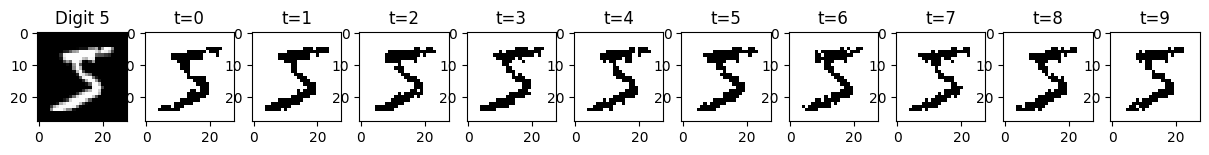

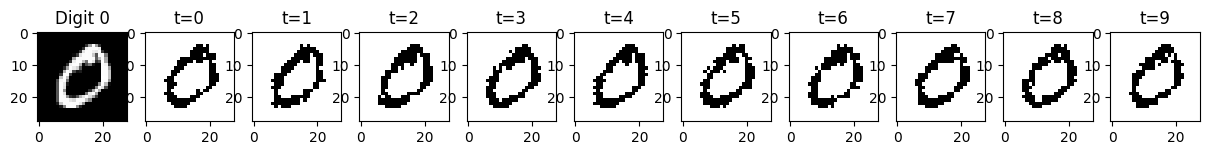

In [4]:
# Visualization:

import matplotlib.pyplot as plt

def visualize_spikes(image, spike_train, digit=3, timesteps=10):
    fig, axes = plt.subplots(1, timesteps+1, figsize=(15,3))

    # Original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f"Digit {digit}")

    # Spike frames at t(i)'s
    for t in range(timesteps):
        axes[t+1].imshow(spike_train[t], cmap='binary')
        axes[t+1].set_title(f"t={t}")
    plt.show()

# Example of '5', first 10 timesteps/25
image, label = train_data[0]  # Digit '5' is just the first example out of 60000 (indices running from 0 to 59999)
spike_train = poisson_encode(image.squeeze(0), timesteps=25)
visualize_spikes(image.squeeze(0), spike_train, digit=label)

# another one
image, label = train_data[1]
spike_train = poisson_encode(image.squeeze(0), timesteps=25)
visualize_spikes(image.squeeze(0), spike_train, digit=label)


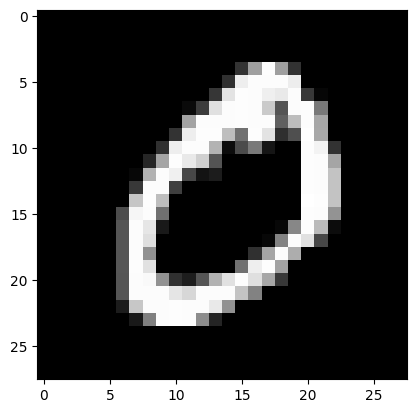

In [5]:
plt.imshow(image.squeeze(0), cmap='gray', origin='upper')

# Task 2: SNN Model

In [6]:
# Surrogate Gradient:

class SurrogateHeaviside(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return (x > 0).float()
    @staticmethod
    def backward(ctx, grad_output):
        x, = ctx.saved_tensors
        beta = 5
        s = torch.sigmoid(beta * x)
        grad = grad_output * beta * (s * (1 - s))
        return grad

surrogate_heaviside = SurrogateHeaviside.apply

In [7]:
# LIF neuron:

# import torch
import torch.nn as nn
import torch.optim as optim

class LIFNeuron(nn.Module):
    def __init__(self, threshold=1.0, beta=0.9):
        super().__init__()
        self.threshold = threshold
        self.beta = beta

    # Modelling the equation: U(t) = B*U(t-1) + Iin(t):
    def forward(self, x, mem):
        if mem is None:
            mem = torch.zeros_like(x)
        mem = self.beta * mem + x # Here x is the external inpit current
        spike = surrogate_heaviside(mem - self.threshold) # Spike if V > Vthreshold
        mem = mem - spike * self.threshold  # Reset after spike
        return spike, mem


In [8]:
# SNN MODEL:

class SNN(nn.Module):
    def __init__(self, input_size=784, hidden_size=500, output_size=10,
                 threshold=1.0, beta=0.9):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input layer (28*28 = 784 pixels)
        self.fc2 = nn.Linear(hidden_size, output_size) # Output layer (10 digits, 0-9)
        self.lif1 = LIFNeuron(threshold, beta)
        self.lif2 = LIFNeuron(threshold, beta)
        # Kaiming initialization
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x, time_steps=25):
        batch_size = x.size(0)
        x = x.view(batch_size, time_steps, -1)  # Reshapong input to [batch_size, time_steps, input_size]
        mem1 = torch.zeros(batch_size, self.fc1.out_features, device=x.device)
        mem2 = torch.zeros(batch_size, self.fc2.out_features, device=x.device)
        output_spikes = []
        for t in range(time_steps):
            input_spikes = x[:, t, :]
            h1 = self.fc1(input_spikes)
            spike1, mem1 = self.lif1(h1, mem1)
            h2 = self.fc2(spike1)
            spike2, mem2 = self.lif2(h2, mem2)
            output_spikes.append(spike2)
        return torch.stack(output_spikes, dim=1) # [batch, time, 10]

model = SNN()


# Task 3: Training and Evaluation

In [9]:
# Training function:

def train_snn(model, dataloader, device, epochs=1, time_steps=25, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    train_losses, train_accuracies = [], []
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in dataloader:
            images = images.squeeze(1).to(device)  # [batch, 28, 28]
            labels = labels.to(device)
            spike_data = poisson_encode(images, timesteps=time_steps).to(device)  # [batch, time, 28, 28]
            spike_data = spike_data.view(images.size(0), time_steps, -1)  # [batch, time, 784]
            output = model(spike_data, time_steps=time_steps)  # [batch, time, 10]
            total_spikes = output.sum(dim=1)  # [batch, 10]
            loss = torch.nn.functional.cross_entropy(total_spikes, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
            preds = total_spikes.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
        epoch_loss = total_loss / total
        epoch_accuracy = correct / total
        print(f"Epoch {epoch+1}: Loss={total_loss/total:.4f}, Accuracy={correct/total:.4f}")
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
    
    # Plotting training loss and accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Loss")
    plt.plot(train_accuracies, label="Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()


Epoch 1: Loss=2.3392, Accuracy=0.1048
Epoch 2: Loss=2.3025, Accuracy=0.1140
Epoch 3: Loss=2.2810, Accuracy=0.1374
Epoch 4: Loss=2.2447, Accuracy=0.1842
Epoch 5: Loss=2.2162, Accuracy=0.2228
Epoch 6: Loss=2.1966, Accuracy=0.2507
Epoch 7: Loss=2.1884, Accuracy=0.2635
Epoch 8: Loss=2.1824, Accuracy=0.2707
Epoch 9: Loss=2.1758, Accuracy=0.2775
Epoch 10: Loss=2.1717, Accuracy=0.2823
Epoch 11: Loss=2.1710, Accuracy=0.2828
Epoch 12: Loss=2.1672, Accuracy=0.2861
Epoch 13: Loss=2.1707, Accuracy=0.2848
Epoch 14: Loss=2.1667, Accuracy=0.2883
Epoch 15: Loss=2.1653, Accuracy=0.2892
Epoch 16: Loss=2.1624, Accuracy=0.2927
Epoch 17: Loss=2.1631, Accuracy=0.2914
Epoch 18: Loss=2.1611, Accuracy=0.2944
Epoch 19: Loss=2.1614, Accuracy=0.2939
Epoch 20: Loss=2.1600, Accuracy=0.2957


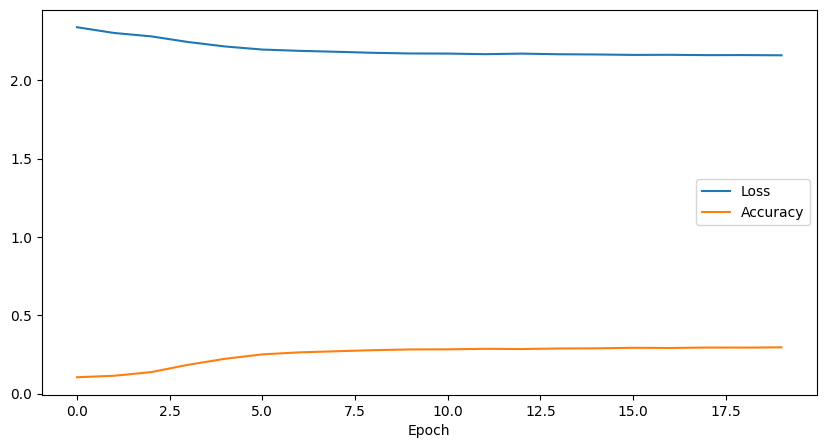

In [10]:
# Prepare DataLoader and train the Model:

from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = SNN().to(device)
train_snn(model, train_loader, device, epochs=20, time_steps=25, lr=1e-4)

In [12]:
# Evaluating the Model:

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

from tqdm import tqdm

def evaluate_snn(model, dataloader, device, time_steps=25):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.squeeze(1).to(device)
            labels = labels.to(device)
            spike_data = poisson_encode(images, timesteps=time_steps)
            # print("Avg spike rate:", spike_data.mean().item())
            spike_data = spike_data.view(images.size(0), time_steps, -1)
            output = model(spike_data, time_steps=time_steps)
            total_spikes = output.sum(dim=1)
            preds = total_spikes.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

evaluate_snn(model, test_loader, device, time_steps=25)


Evaluating: 100%|██████████| 313/313 [00:05<00:00, 55.83it/s]

Test Accuracy: 0.2958


0.2958